<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/neural_networks/GAN/vanilla_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanilla GAN

##Import bibliotek

In [53]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

In [204]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow.keras import layers
import time
from scipy.io import arff
from sklearn.preprocessing import MinMaxScaler

from IPython import display

## Wczytanie danych

In [55]:
path = '/content/'
microarrays = []

for filename in os.listdir(path):
  if os.path.isfile(os.path.join(path, filename)):
    
    if filename[-5:] == '.arff':
      microarray = arff.loadarff(filename)
      microarrays.append(microarray)
      print(filename)

GSE17920_1000_train.arff
GSE10072_1000_train.arff
GSE27272_1000_train.arff
GSE6613_1000_train.arff
GSE3365_1000_train.arff
GSE19804_1000_train.arff
GDS2771_1000_train.arff
GSE25837_1000_train.arff


In [78]:
data = np.asarray(microarrays, dtype=object)
data.shape

(8, 2)

In [86]:
df = pd.DataFrame(data[0][0])
df

,216611_s_at,211753_s_at,208607_s_at,223256_at,204104_at,1569436_at,220086_at,241523_at,232197_x_at,32062_at,220243_at,242499_at,220130_x_at,1568739_at,40850_at,205000_at,205001_s_at,227430_at,205321_at,1553316_at,215366_at,238682_at,241477_at,240340_at,229684_s_at,235389_at,224457_at,212517_at,1555227_a_at,238445_x_at,236589_at,1553668_at,244017_at,210642_at,233795_at,220573_at,204802_at,214456_x_at,243286_at,214846_s_at,...,242361_at,1561942_x_at,205352_at,201660_at,243908_at,208272_at,224832_at,211395_x_at,217595_at,205682_x_at,219512_at,1564479_a_at,222713_s_at,214731_at,213385_at,212441_at,211749_s_at,1553739_at,214804_at,210791_s_at,230097_at,208713_at,201327_s_at,241454_at,205223_at,209118_s_at,216484_x_at,206133_at,207912_s_at,211792_s_at,238599_at,204256_at,217694_at,212320_at,231183_s_at,1558584_at,207110_at,225541_at,236257_at,class
0,3.0343,1.6148,2.2403,4.3852,3.6988,2.1842,3.6308,1.9130,2.3565,3.0205,2.6392,2.4712,2.4294,1.7176,3.5795,8.3740,5.6584,3.5834,3.4548,2.6411,2.1847,2.1792,2.5849,2.5990,2.3499,3.6533,2.0484,3.7731,1.9702,2.4511,2.4182,2.1849,1.7508,2.4463,2.2471,2.7294,4.4662,2.9752,5.3019,2.3581,...,2.7979,2.4446,4.8586,6.2659,4.9121,2.4900,6.0907,5.2830,1.7449,2.6273,3.5485,2.3388,4.2126,3.7269,3.6490,5.7373,6.7304,1.5109,2.3045,2.6605,5.6851,6.4243,7.6007,2.1457,3.4215,10.0763,6.3397,7.3109,1.8399,4.1439,3.1470,2.9117,1.8212,8.8942,5.2042,3.1377,1.8346,9.4305,2.3389,b'yes'
1,2.8775,1.7772,2.3025,5.3689,4.0764,2.1058,3.9518,2.5599,2.2673,3.0866,3.0153,2.2044,2.5212,1.8698,3.2564,8.4904,5.2835,4.3778,3.5954,2.5558,2.4412,2.4593,2.7049,2.5835,2.4358,3.5392,2.0325,3.4390,1.8799,2.6416,2.5550,2.0045,1.9762,2.4866,2.8946,3.0869,4.4385,2.7485,5.4369,3.0321,...,3.2605,2.9362,4.5792,6.4424,4.8516,2.8046,4.8480,5.8813,1.5384,2.6485,3.3540,2.6003,3.8960,3.6532,3.1328,5.7870,5.8729,1.9203,1.9855,2.1897,5.2176,5.9001,7.2338,1.9803,3.3371,10.5122,5.8613,7.0355,1.6671,4.1252,2.1367,2.7471,1.5728,8.0033,5.2796,3.1670,1.8162,9.7741,2.7747,b'yes'
2,3.0410,2.6314,2.3577,5.4729,3.5774,2.1560,4.2415,1.8917,2.3614,3.2144,2.5183,2.3512,2.8683,1.5968,3.6756,7.8987,5.7650,4.3256,4.8882,3.9025,2.0782,2.4443,2.3376,2.2637,2.3064,4.4981,1.8439,3.8132,2.3764,1.9495,2.5470,1.9020,2.0359,2.5774,2.5018,3.1122,3.7527,2.9004,3.4536,2.3765,...,2.4075,2.5485,4.0848,5.9171,3.5046,2.1453,5.4569,5.4152,1.8443,2.8003,3.7661,1.8825,4.7593,2.1888,3.7152,6.1062,6.7641,1.5905,2.1794,2.1385,4.2705,7.0991,8.1189,2.1472,3.4588,9.8468,6.0543,7.4300,1.6430,5.0603,2.6139,1.9096,1.5089,9.6512,3.2889,2.9053,2.1061,9.2880,2.7778,b'yes'
3,2.5068,2.0299,4.9830,5.4105,3.4407,1.7917,3.7767,1.8628,2.0787,3.3344,2.2980,2.1395,2.6844,1.7974,3.5831,7.8836,5.6483,4.6493,4.3931,3.3770,1.8784,2.3234,2.4647,2.2745,2.4275,3.9112,1.9558,4.3772,2.0342,2.2795,2.5038,1.9622,1.9702,2.4588,2.4098,2.8158,3.9835,5.1754,3.7630,2.0503,...,2.3212,2.5361,4.9658,6.4215,3.7797,2.3807,5.5891,7.0590,1.9186,2.9448,3.5649,2.0295,4.7017,2.7674,5.1226,5.8509,7.3993,1.6084,2.1193,2.7524,4.3913,6.3370,8.1642,2.1990,2.9309,10.1669,6.2082,8.3247,1.7566,4.1606,2.9890,3.3704,1.6674,9.1768,4.9638,3.1035,2.0398,9.2504,2.6690,b'yes'
4,2.9993,2.1138,2.1665,4.6354,3.6756,2.1774,3.8409,1.9620,2.5862,3.2808,2.7684,2.2549,2.3521,1.9005,3.6260,8.5144,5.1802,4.2773,4.3503,2.8899,2.0399,2.6794,2.6543,2.5871,2.7286,3.1483,2.1878,3.9861,2.0038,2.8800,2.2966,2.2091,2.0112,2.3800,2.6435,2.7812,4.8119,2.9889,5.1922,2.4252,...,3.2808,2.7822,4.4034,6.0474,4.3969,2.6251,6.2703,5.7220,1.6291,2.5389,3.1853,2.6220,4.4066,3.4467,3.3569,6.0879,6.8668,1.5355,2.2934,2.5520,4.6419,6.8523,7.7585,2.3301,3.6390,10.0027,6.3342,7.0319,1.6565,4.3050,2.8827,2.7151,1.4636,9.3343,3.8570,3.2463,2.0936,8.8280,2.5560,b'yes'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

##Normalizacja

In [87]:
x = df.select_dtypes(include=[np.number])
scaler = MinMaxScaler(feature_range=(0, 1))
x_norm = scaler.fit_transform(x)

df2 = pd.DataFrame(x_norm)
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.465110,0.000000,0.148917,0.151541,0.723217,0.535352,0.133369,0.328803,0.462888,0.299819,0.396834,0.476719,0.287711,0.306690,0.439618,0.979887,0.973787,0.126012,0.227554,0.287908,0.399732,0.358056,0.338887,0.503972,0.281208,0.202456,0.334430,0.373678,0.276783,0.297533,0.385222,0.395197,0.059861,0.340929,0.000000,0.202824,0.650225,0.161617,0.857968,0.320523,...,0.355835,0.507473,0.189200,0.558020,0.592217,0.785147,0.409426,0.690734,0.349621,0.302032,0.277138,0.462618,0.429264,0.381565,0.896583,0.425321,0.586068,0.552911,0.182333,0.225751,0.457031,0.665271,0.580410,0.630492,0.287234,0.614204,0.706433,0.715395,0.413473,0.593957,0.514652,0.417800,0.640581,0.702145,0.625273,0.762325,0.433724,0.235000,0.462320,0.035072
1,0.355144,0.075304,0.168218,0.616515,0.923780,0.447084,0.377587,1.000000,0.397401,0.366411,0.616544,0.232172,0.337061,0.513231,0.217922,0.996562,0.881599,0.649022,0.257097,0.239754,0.628954,0.610171,0.419176,0.490874,0.334030,0.168203,0.321667,0.213845,0.193025,0.390787,0.521817,0.226614,0.296576,0.373265,0.416935,0.457781,0.643094,0.087118,0.908950,0.818639,...,0.495981,0.804221,0.503743,0.487446,0.651631,0.763399,0.685536,0.301307,0.445224,0.090107,0.289591,0.359996,0.637101,0.208370,0.856989,0.305210,0.612040,0.296143,0.777132,0.023916,0.159094,0.542911,0.367095,0.466500,0.162442,0.551308,0.883011,0.460900,0.340689,0.359843,0.505968,0.091297,0.561457,0.301564,0.347370,0.784828,0.458943,0.220377,0.558723,0.363062
2,0.469809,0.471390,0.185347,0.665674,0.658735,0.503603,0.597991,0.306703,0.466486,0.495164,0.326206,0.366728,0.523653,0.142760,0.505558,0.911798,1.000000,0.614655,0.528733,1.000000,0.304558,0.596670,0.173424,0.220635,0.254458,0.456066,0.170266,0.392862,0.653557,0.051987,0.513829,0.130829,0.359273,0.446121,0.164005,0.475824,0.466547,0.137036,0.159970,0.334122,...,0.166979,0.257040,0.255679,0.362566,0.474804,0.279198,0.106898,0.492119,0.370746,0.404044,0.378759,0.577428,0.066603,0.680635,0.070270,0.440724,0.778846,0.563002,0.297981,0.146599,0.126693,0.295024,0.855009,0.862111,0.288366,0.642000,0.613465,0.563571,0.444950,0.327191,0.940231,0.245516,0.158871,0.198516,0.861407,0.190731,0.233689,0.450767,0.422339,0.365395
3,0.095168,0.192479,1.000000,0.636179,0.586126,0.093447,0.244370,0.276717,0.258938,0.616059,0.197511,0.172686,0.424793,0.414982,0.442089,0.909635,0.971304,0.827770,0.424705,0.703342,0.126005,0.487849,0.258464,0.229762,0.328926,0.279878,0.260095,0.662680,0.336147,0.213530,0.470694,0.187085,0.290275,0.350959,0.104765,0.264442,0.525962,0.884653,0.276813,0.093046,...,0.230918,0.201681,0.247745,0.585097,0.644596,0.378087,0.313498,0.533546,0.633409,0.480296,0.463640,0.471271,0.183437,0.649125,0.381111,0.768202,0.645433,0.753204,0.323987,0.108573,0.515188,0.326642,0.544885,0.882358,0.327448,0.248603,0.743134,0.645441,0.681405,0.481100,0.522407,0.366739,0.861078,0.454120,0.713426,0.690581,0.404286,0.398077,0.411789,0.283510
4,0.440564,0.231383,0.126016,0.269805,0.710894,0.527696,0.293214,0.379643,0.631525,0.562059,0.472310,0.278460,0.246156,0.554892,0.471525,1.000000,0.856198,0.582856,0.415712,0.428362,0.270331,0.808281,0.385320,0.493916,0.514082,0.050854,0.446335,0.475578,0.307949,0.507490,0.263804,0.417811,0.333333,0.287732,0.255248,0.239766,0.739220,0.166119,0.816541,0.370113,...,0.444854,0.817243,0.405208,0.443041,0.518666,0.599950,0.527997,0.747015,0.419769,0.183190,0.225211,0.270986,0.654347,0.487691,0.746051,0.357354,0.769283,0.593754,0.218074,0.218728,0.388369,0.392232,0.754578,0.701024,0.426362,0.776287,0.676618,0.712469,0.339738,0.345482,0.589467,0.332385,0.546075,0.125464,0.762555,0.360272,0.527199,0.440833,0.293278,0.198465


##Podział na zbiór treningowy i walidacyjny

In [108]:
# Podział w stosunku 100 do 30
x_train = x_norm[:100]
x_val = x_norm[-30:]

print(x_train.shape)
print(x_val.shape)

(100, 1000)
(30, 1000)


In [109]:
BUFFER_SIZE = 100
BATCH_SIZE = 20

# Podzielenie na wsady i przetasowanie danych
train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Stworzenie modeli
### Generator

In [95]:
def make_generator_model():
  model = tf.keras.Sequential()
  
  # Warstwa wejściowa
  model.add(layers.Dense(256, input_dim=100))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))

  # Warstwa ukryta
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))

  # Warstwa wyjściowa
  model.add(layers.Dense(1000))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Reshape((20, 50, 1)))

  return model

In [111]:
generator = make_generator_model()
generator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dense_20 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
dense_21 (Dense)             (None, 1000)             

Użycie (jeszcze niewytrenowanego) generatora do stworzenia obrazu mikromacierzy.

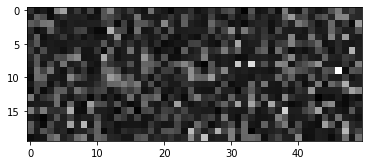

In [96]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Dyskryminator

In [115]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  
  # Wartstwa wejściowa
  model.add(layers.Flatten(input_shape=(20, 50, 1)))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))

  # Wartstwa ukryta
  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU(alpha=0.2))

  # Wartstwa wyjściowa
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [116]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               512512    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 644,097
Trainable params: 644,097
Non-trainable params: 0
_______________________________________________

Użycie (jeszcze niewytrenowanego) dyskryminatora do sklasyfikowania wygenerowanych mikromacierzy jako rzeczywiste albo nierealne. Model będzie uczony na dodatnich wartościach dla macierzy rzeczywistych i ujemnych dla nierealnych.

In [117]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5248994]], shape=(1, 1), dtype=float32)


## Deklaracja straty i optymalizatora

In [163]:
# ten model zwraca funkcję pomocniczą do obliczenia entropii krzyżowej straty
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Strata dyskryminatora

In [183]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

### Strata generatora

In [185]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

Dyskryminator i generator są różne, ponieważ są trenowane jako dwie niezależne sieci.

In [102]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Zapisanie punktów kontrolnych

In [48]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Pętla treningowa

In [125]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# będziemy używać tego seeda z biegiem czasu
# do wizualizacji postępów na animowanym gifie
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [187]:
# używamy tf.function
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [140]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # zapis modelu co 15 epok
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  # generowanie po ostatniej epoce
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

Generowanie i zapis obrazów mikromacierzy

In [127]:
def generate_and_save_images(model, epoch, test_input):
  # zauważ, że 'training' ustawiony jest na fałsz
  # wszystkie warstwy działają w trybie wnioskowania inference mode(batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.axis()

## Trenowanie modelu
Wywołujemy metodę `train()` na generatorze i dyskryminatorze równocześnie. Ponieważ GANy mogą być zdradzieckie, ważne jest aby generator i dyskryminator nie zwalczały siebie nawzajem.

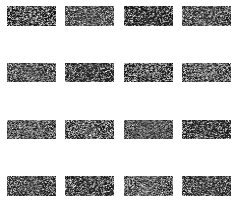

In [188]:
train(train_data, EPOCHS)

Przywracamy ostatni checkpoint.

In [189]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Zapisanie wyników do plików .arff

In [195]:
predictions = generator(seed, training=False)
predictions.shape

TensorShape([16, 20, 50, 1])

In [197]:
flatten = np.reshape(predictions, [num_examples_to_generate, 1000])
flatten.shape

(16, 1000)

In [209]:
df = pd.DataFrame(flatten)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,-0.057717,2.453460,1.800470,-0.728795,0.421768,-0.853065,1.524206,0.855935,2.040616,-0.891935,-0.724596,1.369201,-0.465792,1.301085,-0.270814,-0.000650,-0.524947,1.166868,1.854728,2.424617,-0.691903,-0.449714,1.608308,-0.933818,0.120402,-0.479619,-1.156406,1.115575,0.109462,0.030318,-0.377196,1.867953,-0.758380,-0.571163,-0.040222,0.771603,1.391278,1.635502,1.833469,-0.587481,...,-0.757886,-0.625024,-0.462244,1.852980,-0.797585,-0.993547,1.470053,1.144109,-0.626105,0.578733,0.796796,-0.023616,0.273550,-0.570340,0.856438,1.597502,2.749734,-0.675430,-1.163644,-0.639490,-0.662754,1.244476,-0.632668,2.065985,1.909438,-0.746083,-0.416185,0.485561,-0.611853,-0.524589,-1.174123,-0.602674,1.423607,0.221864,-0.084785,-0.850937,-0.520208,-0.882482,-0.716060,-0.112958
1,-0.410300,-0.563735,-0.018560,0.942324,0.274500,0.660002,-0.518960,-0.580859,-0.586660,-0.364077,0.717110,-0.414608,-0.118615,-0.052623,0.116903,-0.516264,0.755966,0.069765,-0.594752,-0.592758,0.068599,-0.798473,-0.559743,0.847850,-0.343250,-0.414040,0.442192,-0.246111,0.032730,0.555756,0.457461,-0.429904,0.901631,0.529527,-0.176078,-0.043570,-0.431809,-0.610742,-0.692049,0.160839,...,0.938947,0.246458,-0.281002,-0.611477,1.014935,0.410904,-0.015508,0.715578,0.916381,-0.034114,-0.492049,-0.003832,-0.430814,0.278317,-0.609646,-0.549430,-0.463964,-0.091467,0.325251,0.013630,-0.177042,-0.109195,0.365187,-0.511615,-0.667630,0.587847,0.451953,-0.732307,0.555607,0.390208,0.443503,0.867867,-0.666644,0.049147,0.368940,0.703321,0.215355,1.546247,0.194104,0.181450
2,0.057357,-0.446765,-1.033725,1.416330,0.592107,-0.245366,-0.786939,-0.838374,-0.789006,1.406183,-0.159667,-0.413114,1.031150,-0.576580,-0.782460,2.817256,0.162775,-0.696359,-0.717912,-0.791414,-0.347575,2.762850,-0.886500,1.004482,2.020229,0.918081,1.871869,-0.904266,1.781006,-1.261322,0.757256,-0.813969,0.556878,1.684252,1.366503,-0.115654,-0.484604,-0.819841,0.663055,-0.020986,...,2.146767,2.032609,-0.894518,-0.831031,0.894261,1.422443,-0.745331,-0.995800,1.109009,-0.798880,1.576140,0.401354,0.638170,2.186426,-0.938309,-0.159649,-0.416307,1.832338,2.139846,2.892024,1.409780,-1.143201,1.764757,-0.231873,-0.621906,1.703311,-0.861414,-0.778421,1.157531,1.334999,-0.087413,-0.870606,-0.758028,-0.439804,1.244642,0.665907,-0.709238,1.095168,0.556412,-0.210065
3,-0.232873,-0.190474,-0.806942,0.125873,0.183155,-0.283493,-0.104931,-0.154041,-0.437945,0.723342,-0.003759,-0.373345,0.210590,-0.146750,-0.176753,0.760840,0.724386,0.454740,-0.493186,-0.165895,0.278987,0.356494,-0.677952,0.673441,0.348740,0.210953,0.488999,-0.702870,0.427427,-0.624177,-0.362904,-0.462134,1.268161,0.431180,0.659863,0.265886,-0.048630,-0.283222,-0.160751,0.422094,...,0.701163,0.535538,-0.038400,-0.509309,0.667180,0.528162,-0.417673,-0.478889,-0.004044,-0.595248,-0.088964,-0.039797,0.685641,0.106755,-0.612987,0.209845,-0.395811,1.061790,0.887719,1.187463,0.629683,-0.546703,0.304844,0.123034,-0.056004,0.746031,-0.129524,-0.399404,0.605600,0.828388,0.752195,-0.683331,-0.321772,0.059286,1.097713,-0.011383,-0.484732,0.825613,1.456053,-0.084029
4,-0.167997,-0.106507,0.292892,-0.237803,1.305623,-0.855072,-0.522503,-0.272187,-0.179787,0.047349,-0.450732,0.579751,0.823455,-0.094193,-0.162586,0.222345,-0.146669,0.632149,-0.507840,0.186503,-0.461661,0.382606,-0.353597,0.065613,-0.444812,0.305104,0.384739,-0.404338,1.590863,0.214481,0.540880,-0.390971,-0.262521,0.372833,1.643340,-0.803846,-0.372273,-0.592584,0.026020,-0.580008,...,0.221078,0.527020,-0.850550,-0.535499,-0.169655,0.245953,-0.428845,-0.613304,1.075408,-0.666245,-0.510592,0.374819,0.882874,-0.310419,-0.505773,0.173932,0.916475,0.130764,0.611634,0.345090,-0.311114,-0.791601,0.700954,1.108730,0.637416,0.363601,0.045874,-0.814019,0.3

In [214]:
result = df.to_string
result

<bound method DataFrame.to_string of          0         1         2    ...       997       998       999
0  -0.057717  2.453460  1.800470  ... -0.882482 -0.716060 -0.112958
1  -0.410300 -0.563735 -0.018560  ...  1.546247  0.194104  0.181450
2   0.057357 -0.446765 -1.033725  ...  1.095168  0.556412 -0.210065
3  -0.232873 -0.190474 -0.806942  ...  0.825613  1.456053 -0.084029
4  -0.167997 -0.106507  0.292892  ...  0.523136 -0.342240 -0.142323
5  -0.414883  0.306691 -0.817096  ...  0.282699  1.822349  0.229227
6   0.998633  1.811352  1.595619  ... -0.947530 -0.609388 -0.225987
7   1.013031  1.495293  0.935168  ... -0.612228 -0.623565 -0.087330
8   1.913841  0.797425  1.324748  ... -0.513071 -0.613035  0.271459
9   0.373308  0.388834  0.380781  ... -0.407883 -0.635886 -0.721828
10  0.130354  1.161690 -0.453938  ... -0.328749 -0.286668  0.448202
11 -0.153399 -0.702488 -0.762031  ...  2.366035  0.211074  0.760442
12  1.289774 -0.281715  0.533050  ... -0.348582 -0.509831 -0.776938
13 -0.41025